In [1]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import numpy as np
from pandas import Series
import seaborn as sns
from matplotlib.pyplot import figure
import cmocean.cm as cmo
import seaborn as sns

from pylab import rcParams
from numpy import diff
from scipy import interpolate
import scipy.stats as stats

from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

import matplotlib.gridspec as gridspec
from IPython.display import display, Math

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
df_iron = pd.read_csv('../Dissertation_projects/Data/IRON/Iron.csv', sep=',', index_col=0)

#make all the spots labeled NA a nan value
df_iron = df_iron.replace('NA', np.nan)
df_iron = df_iron.replace('NA ', np.nan)

#make all BDL a 0 
df_iron.loc[df_iron['FeT_uM'] == 'BLD', 'FeT_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] == 'BLD', 'Fe2_uM'] = 0

# convert columns to numeric data type
df_iron['FeT_uM'] = pd.to_numeric(df_iron['FeT_uM'], errors='coerce')
df_iron['Fe2_uM'] = pd.to_numeric(df_iron['Fe2_uM'], errors='coerce')

df_iron['FeT_uM'] = df_iron['FeT_uM'].where(pd.notna(df_iron['FeT_uM']), other=np.nan)
df_iron['Fe2_uM'] = df_iron['Fe2_uM'].where(pd.notna(df_iron['Fe2_uM']), other=np.nan)

#make all negative a 0 
df_iron.loc[df_iron['FeT_uM'] < 0, 'FeT_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] < 0, 'Fe2_uM'] = 0

#calculate Fe +3 
df_iron['Fe3_uM'] = df_iron['FeT_uM'] - df_iron['Fe2_uM']
df_iron.loc[df_iron['Fe3_uM'] < 0, 'Fe3_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] > df_iron['FeT_uM'], 'Fe3_uM'] = 0
df_iron['Fe3_uM'] = pd.to_numeric(df_iron['Fe3_uM'], errors='coerce')
df_iron['Fe3_uM'] = df_iron['Fe3_uM'].where(pd.notna(df_iron['Fe3_uM']), other=np.nan)

#time feild 
df_iron['Fe2_Time'] = pd.to_numeric(df_iron['Fe2_Time'], errors='coerce')
df_iron['Fe2_Time'] = df_iron['Fe2_Time'].where(pd.notna(df_iron['Fe2_Time']), other=np.nan)

#time feild 
df_iron['FeT_Time'] = pd.to_numeric(df_iron['FeT_Time'], errors='coerce')
df_iron['FeT_Time'] = df_iron['FeT_Time'].where(pd.notna(df_iron['FeT_Time']), other=np.nan)

# convert columns to numeric data type
df_iron['FeT_Depth'] = pd.to_numeric(df_iron['Fe2_Depth'], errors='coerce')
df_iron['Fe2_Depth'] = pd.to_numeric(df_iron['Fe2_Depth'], errors='coerce')

df_iron['code'] = df_iron['Location'] + '_' + df_iron['Campaign']

In [3]:
df_doc = pd.read_csv('../Dissertation_projects/Data/TOC/TOC_GOM.csv', sep=',', index_col=0)

#make all BDL a 0 
df_doc.loc[df_doc['NPOC_uM'] == 'BLD', 'NPOC_uM'] = 0
df_doc.loc[df_doc['TN_uM'] == 'BLD', 'TN_uM'] = 0

df_doc.loc[df_doc['NPOC_uM'] < 0, 'NPOC_uM'] = 0
df_doc.loc[df_doc['TN_uM'] < 0, 'TN_uM'] = 0

#fix date time 
df_doc['date_time'] = pd.to_datetime(df_doc['Date'])
df_doc['Date'] = df_doc['date_time'].dt.date

df_doc['NPOC_uM'] = pd.to_numeric(df_doc['NPOC_uM'], errors='coerce')
df_doc['NPOC_uM'] = df_doc['NPOC_uM'].where(pd.notna(df_doc['NPOC_uM']), other=np.nan)

df_doc['TN_uM'] = pd.to_numeric(df_doc['TN_uM'], errors='coerce')
df_doc['TN_uM'] = df_doc['TN_uM'].where(pd.notna(df_doc['TN_uM']), other=np.nan)

df_doc['Time'] = pd.to_numeric(df_doc['Time'], errors='coerce')
df_doc['Time'] = df_doc['Time'].where(pd.notna(df_doc['Time']), other=np.nan)

df_doc['code'] = df_doc['Location'] + '_' + df_doc['Campaign']

In [4]:
df_meta = pd.read_csv('../Dissertation_projects/Data/meta_data.csv', sep=',', index_col=0)

#fix date time 
df_meta['date_time'] = pd.to_datetime(df_meta['Date'])
df_meta['Date'] = df_meta['date_time'].dt.date

df_meta['code'] = df_meta['Station'] + '_' + df_meta['Trip']

In [5]:
df_c = pd.read_csv('../Dissertation_projects/Data/CDOM/Outputs.csv', sep=',', index_col=0)

df_c['Sample_idx'] = df_c.index.astype(object)
df_meta['Sample_idx'] = df_meta.index.astype(object)

df_c.index = df_c['file_id']

df_cdom = df_c.merge(df_meta, on="Sample_idx", how="left")

df_cdom.index = df_cdom['Sample_idx']
df_cdom['Sample'] = df_cdom.index
df_cdom.index = df_cdom['Sample']
df_cdom = df_cdom.drop('Sample_idx', axis = 1)
df_meta = df_meta.drop('Sample_idx', axis = 1)

In [6]:
df_spectra_pw = pd.read_csv('../Dissertation_projects/Data/CDOM/sprectra_pchip_baseline_corrected_PW.csv',sep=',', index_col=0)
df_spectra_rz = pd.read_csv('../Dissertation_projects/Data/CDOM/sprectra_pchip_baseline_corrected_RZ.csv',sep=',', index_col=0)

df_spectra_pw.columns = ['a' + col for col in df_spectra_pw.columns]
df_spectra_rz.columns = ['a' + col for col in df_spectra_rz.columns]

In [7]:
#get PW data sets 
df_cdom_pw = df_cdom[df_cdom['Type'] == 'PW']
df_iron_pw = df_iron[df_iron['Type'] == 'PW']
df_doc_pw = df_doc[df_doc['Type'] == 'PW']

#get RHZ data 
df_cdom_rz = df_cdom[df_cdom['Type'] == 'RHZ']
df_iron_rz = df_iron[df_iron['Type'].isin(['RZ', 'GBRZ'])]
df_doc_rz = df_doc[df_doc['Type'] == 'RZ']

In [8]:
#Put all the PW data together 
#remove repeat rows 
df_cdom_pw_cl = df_cdom_pw.drop(['Date', 'Type', 'Notes', 'date_time', 'code', 
                                 'Trip', 'Station', 'Lat', 'Lon', 'Water_depth', 'Sample_depth',
                                 'Sample_depth_units', 'Wavguide_Path_lengths', 'BC_time',
                                 'BC_Chamber_vol_(L)', 'Waveguide_used', 'Flagged', 'file_id'], axis=1)
df_iron_pw_cl = df_iron_pw.drop(['Treatment', 'Campaign', 'Location', 'Type', 'code'], axis=1)

#combind DOC and CDOM data 
df_pw = df_spectra_pw.join(df_doc_pw)
df_pw = df_pw.join(df_cdom_pw_cl)

#match up the inxdes for the merge 
df_iron_pw_cl['sample_index'] = df_iron_pw_cl.index.astype(str)
df_pw.index = df_pw.index.astype(str)

#combind the iron data 
df_pw = df_pw.join(df_iron_pw_cl)

df_pw.loc[df_pw['NPOC_uM'] > 5000, 'NPOC_uM'] = np.nan


In [9]:
#remove repeat rows 
df_cdom_rz_cl = df_cdom_rz.drop(['Date', 'Type', 'Notes', 'date_time', 'code', 
                                 'Trip', 'Station', 'Lat', 'Lon', 'Water_depth', 'Sample_depth',
                                 'Sample_depth_units', 'Wavguide_Path_lengths', 'BC_time',
                                 'BC_Chamber_vol_(L)', 'Waveguide_used', 'Flagged', 'file_id'], axis=1)
df_iron_rz_cl = df_iron_rz.drop(['Treatment', 'Campaign', 'Location', 'Type', 'code'], axis=1)

#combind DOC and CDOM data 
df_rz = df_spectra_rz.join(df_doc_rz)
df_rz = df_rz.join(df_cdom_rz_cl)

#match up the inxdes for the merge 
df_iron_rz_cl['sample_index'] = df_iron_rz_cl.index.astype(str)
df_rz.index = df_rz.index.astype(str)

#combind the iron data 
df_rz = df_rz.join(df_iron_rz_cl)


In [10]:
codes_list_1 = df_iron_rz['code'].unique().tolist()
codes_list_2 = df_doc_rz['code'].unique().tolist()
codes_list_3 = df_cdom_rz['code'].unique().tolist()

codes_list_all = codes_list_1 + codes_list_2 + codes_list_3

codes_list = list(set(codes_list_all))
codes_list

['St.7_GOM22SP',
 'St.MK_GOM22SP',
 'St.12_GOM21FA',
 'St.2_GOM21FA',
 'St.5B_GOM22SU',
 'St.14_GOM22SP',
 'St.4_GOM22SP',
 'St.MK_GOM21FA',
 'St.MK_GOM22SU',
 'St.7_GOM22SU',
 'St.9_GOM21FA',
 'St.11_GOM21FA',
 'St.13_GOM22SP',
 'St.14_GOM21FA',
 'St.16_GOM22SP',
 'St.14_GOM22SU',
 'St.16_GOM22SU',
 'St.15_GOM22SP',
 'St.5B_GOM22SP',
 'St.16_GOM21FA',
 'St.13_GOM21FA',
 'St.2_GOM22SP',
 'St.11_GOM22SU',
 'St.13_GOM22SU',
 'St.9_GOM22SP',
 'St.4_GOM22SU']

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_11696\4267316194.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_11696\4267316194.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_11696\4267316194.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
C:\Users\hmlbr\AppD

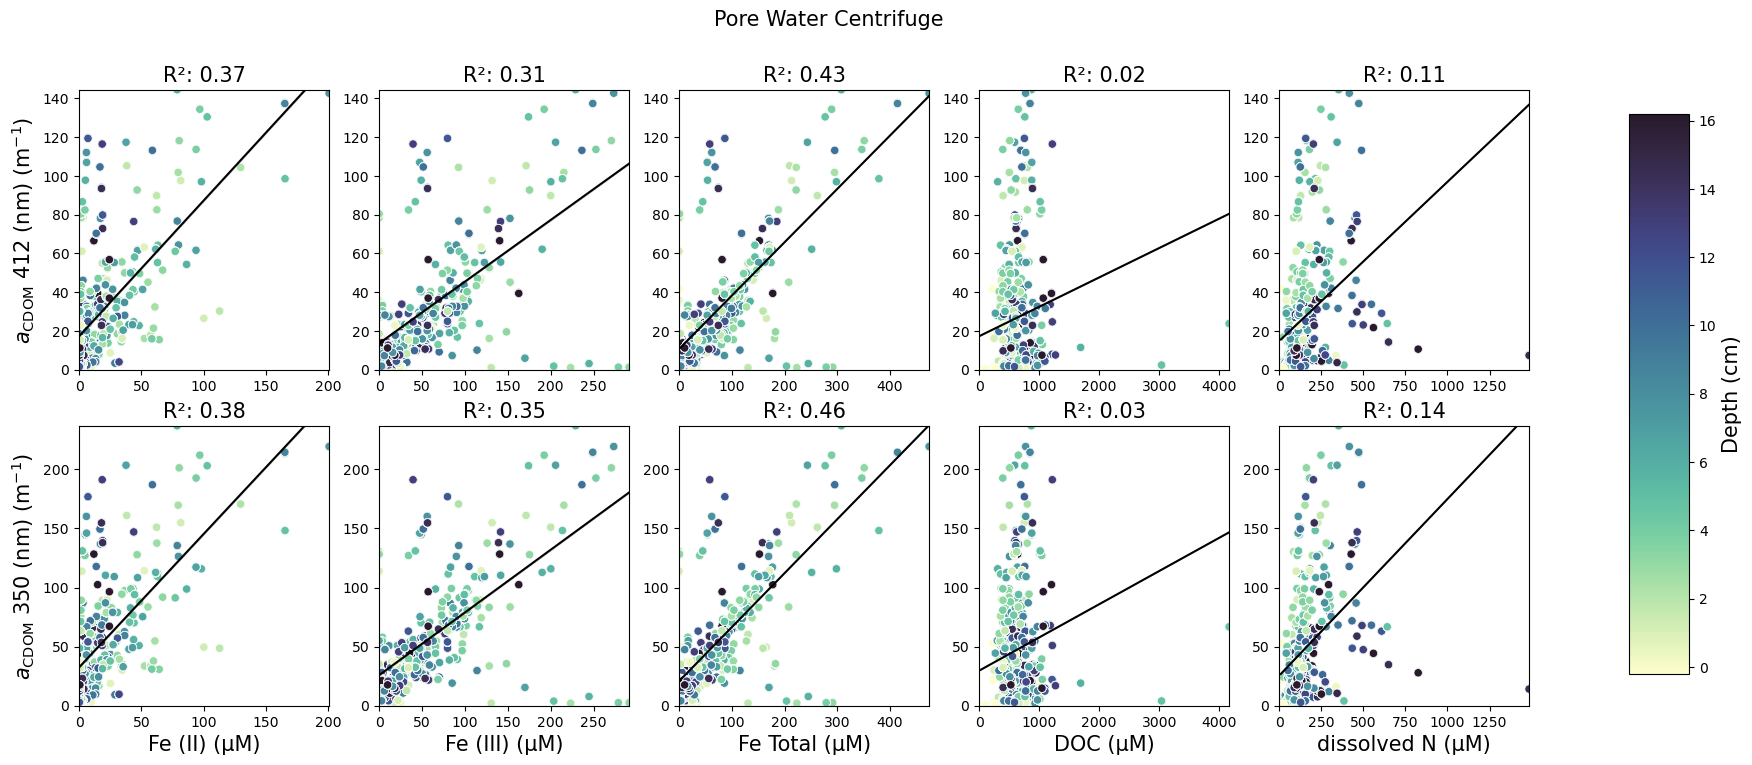

In [11]:
def cor_plot(data_frame, title):
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
    
    # Set up the color bar limits
    vmin = data_frame['Depth'].min()
    vmax = data_frame['Depth'].max()

    # Loop through the subplots
    for i, x_var in enumerate(['Fe2_uM', 'Fe3_uM', 'FeT_uM', 'NPOC_uM', 'TN_uM']):
        for j, y_var in enumerate(['a412', 'a350']):
            # Prepare the data for the subplot
            data = data_frame[[x_var, y_var, 'Depth']]
            data.dropna(inplace=True)
            X = data[[x_var]]
            y = data[y_var]
            colors = data['Depth']

            # Fit a linear regression model to the data
            model = LinearRegression()
            model.fit(X, y)
            score = model.score(X, y)

            # Plot the data and regression line
            ax = axes[j, i]
            sns.scatterplot(x=x_var, y=y_var, data=data, ax=ax, c=colors, cmap=cmo.deep, vmin=vmin, vmax=vmax, legend=False)
            sns.lineplot(x=X[x_var], y=model.predict(X), ax=ax, color='black')

            # Set the axis labels and title
            if j == 1:
                ax.set_xlabel(x_var.replace('Fe2_uM', 'Fe (II) (\u03BCM)').replace('Fe3_uM', 'Fe (III) (\u03BCM)').replace('FeT_uM', 'Fe Total (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('TN_uM', 'dissolved N (\u03BCM)'), size=15)
            else: 
                ax.set_xlabel("")
            if i == 0:
                ax.set_ylabel(y_var.replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'), size = 15)
            else: 
                ax.set_ylabel("")
            ax.set_title(f'R\u00B2: {score:.2f}', size = 15)
            ax.set_ylim([0, data[y_var].max()])
            ax.set_xlim([0, data[x_var].max()])

    # Add a color bar for the depth on the right side of the figure
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([.9, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmo.deep, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
    cbar.ax.set_ylabel('Depth (cm)', size = 15)
        
    # Adjust the layout of the subplots
    fig.suptitle(title, size = 15)
    fig.set_facecolor('w')
    #plt.tight_layout()

    plt.show()

df = df_pw[df_pw['code'].isin(codes_list)]
df = df.loc[df['Depth'] < 16.5] 
cor_plot(df, 'Pore Water Centrifuge')

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_11696\4267316194.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_11696\4267316194.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_11696\4267316194.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
C:\Users\hmlbr\AppD

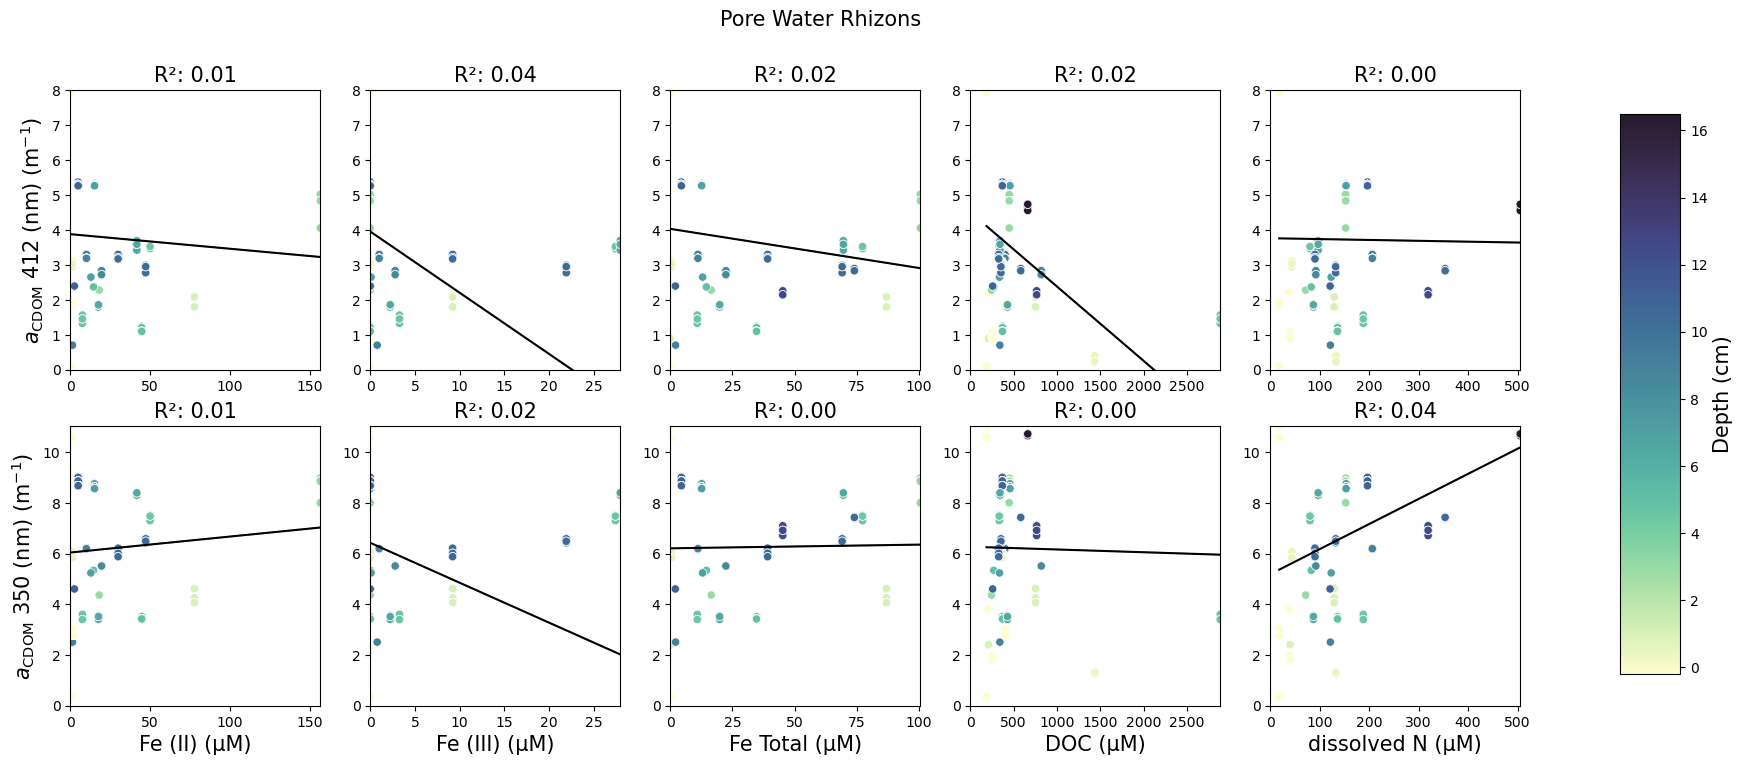

In [12]:
df = df_rz
cor_plot(df, 'Pore Water Rhizons')

In [13]:
df_spectra_pw = df_spectra_pw.join(df_meta)
df_spectra_rz = df_spectra_rz.join(df_meta)

In [14]:
codes_list

['St.7_GOM22SP',
 'St.MK_GOM22SP',
 'St.12_GOM21FA',
 'St.2_GOM21FA',
 'St.5B_GOM22SU',
 'St.14_GOM22SP',
 'St.4_GOM22SP',
 'St.MK_GOM21FA',
 'St.MK_GOM22SU',
 'St.7_GOM22SU',
 'St.9_GOM21FA',
 'St.11_GOM21FA',
 'St.13_GOM22SP',
 'St.14_GOM21FA',
 'St.16_GOM22SP',
 'St.14_GOM22SU',
 'St.16_GOM22SU',
 'St.15_GOM22SP',
 'St.5B_GOM22SP',
 'St.16_GOM21FA',
 'St.13_GOM21FA',
 'St.2_GOM22SP',
 'St.11_GOM22SU',
 'St.13_GOM22SU',
 'St.9_GOM22SP',
 'St.4_GOM22SU']

In [15]:
data_spectra_pw = df_spectra_pw[df_spectra_pw['code'] == codes_list[1]] 
data_spectra_pw.to_csv('../play.csv')

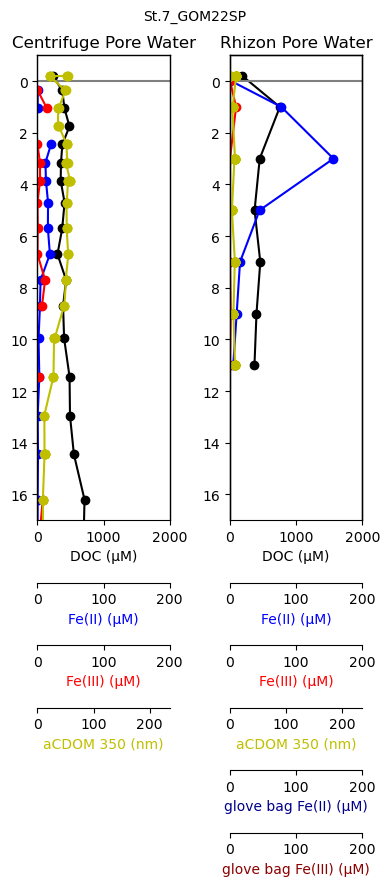

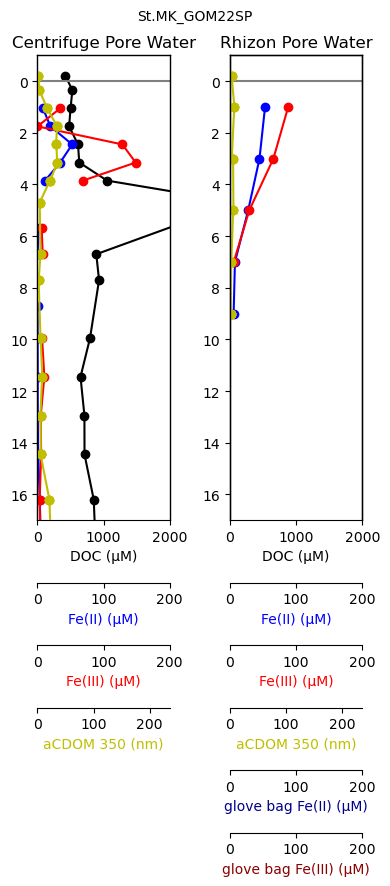

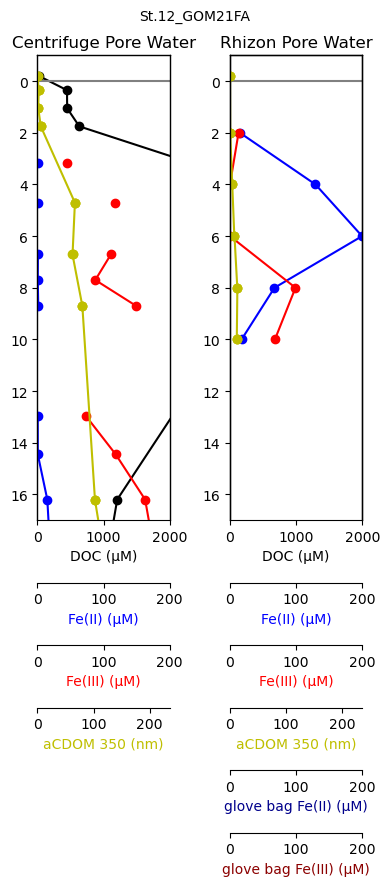

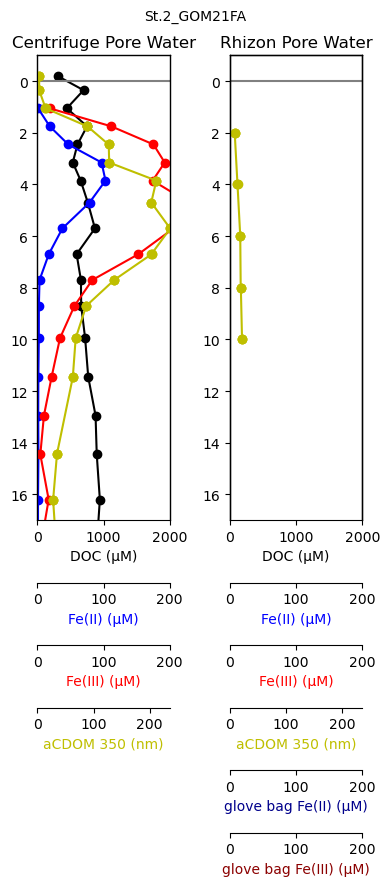

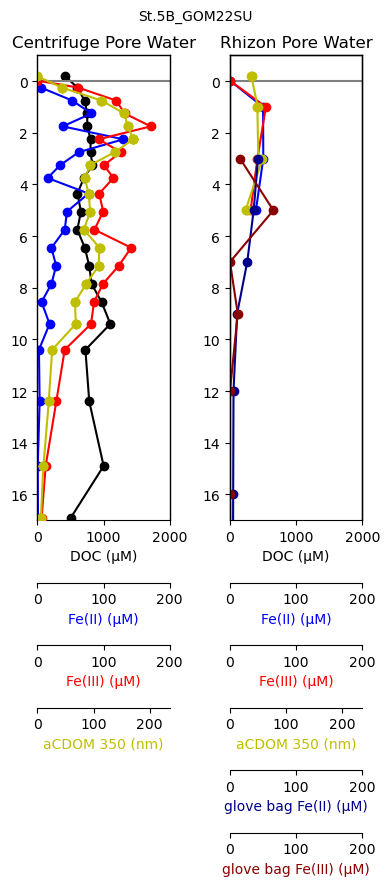

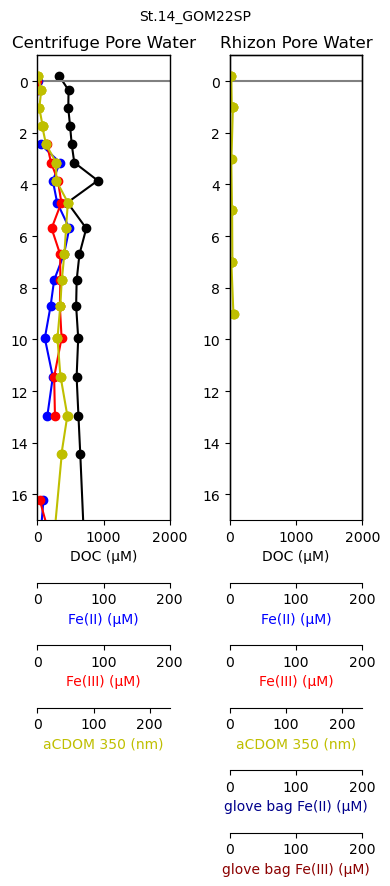

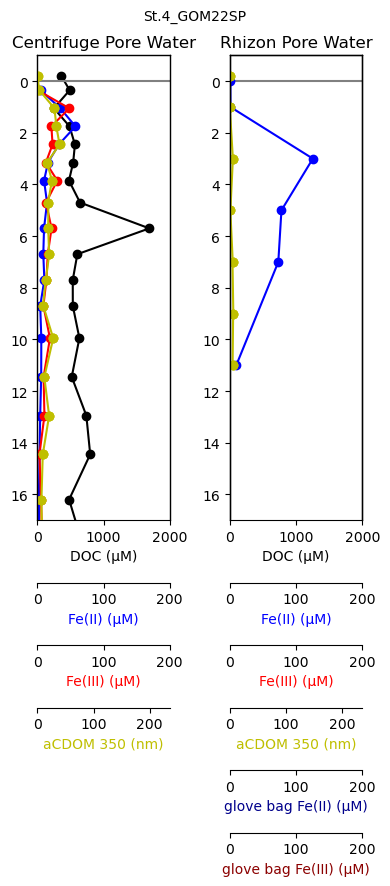

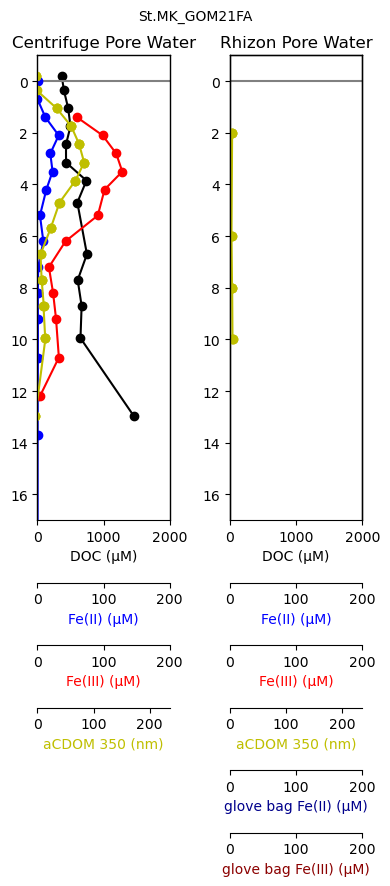

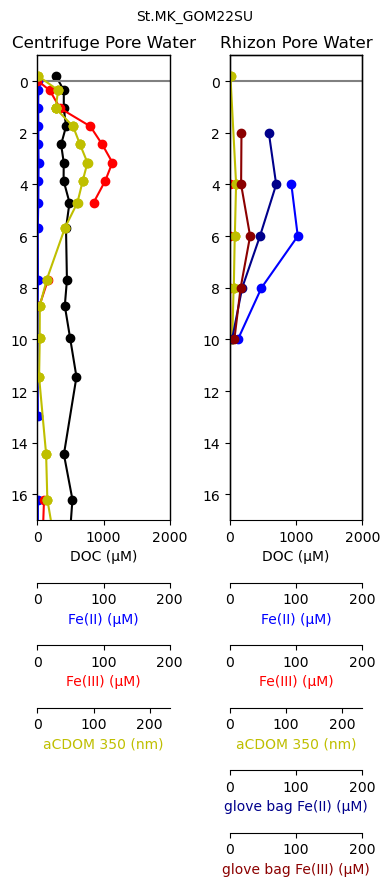

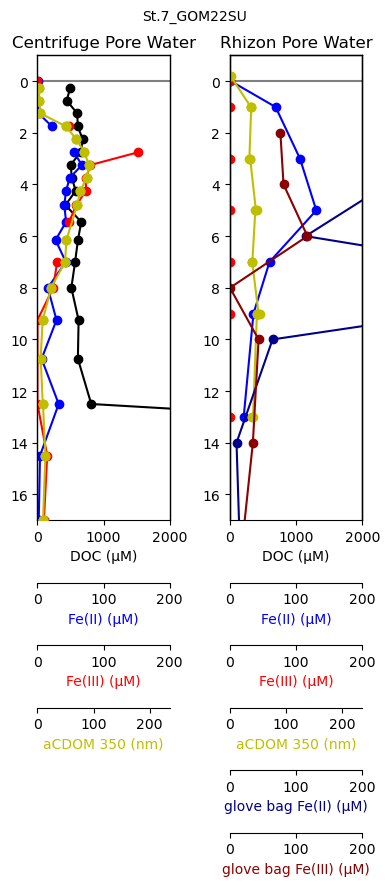

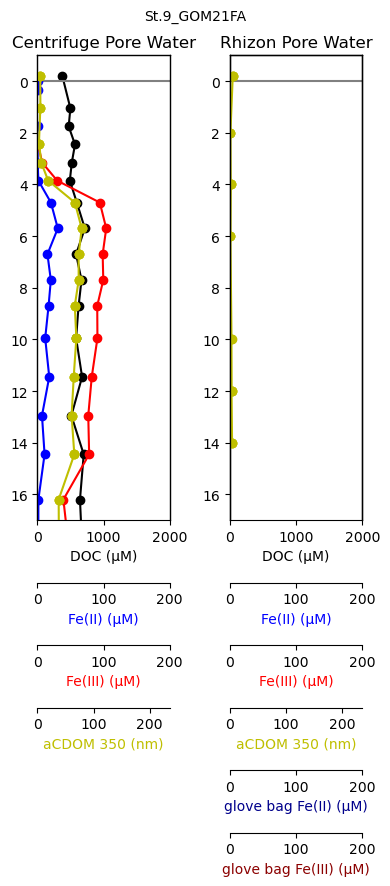

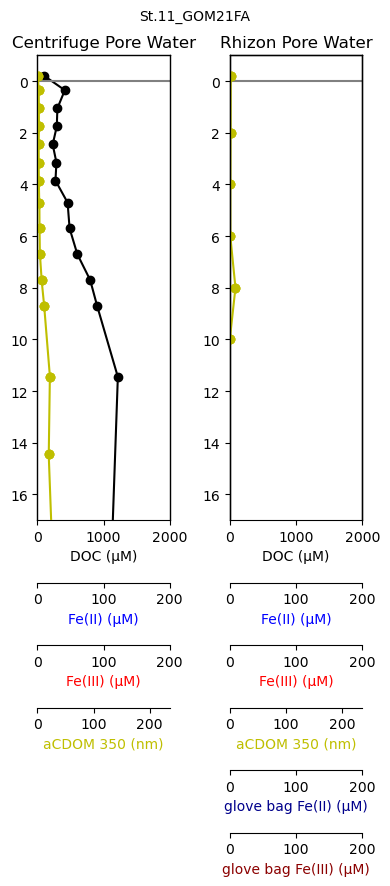

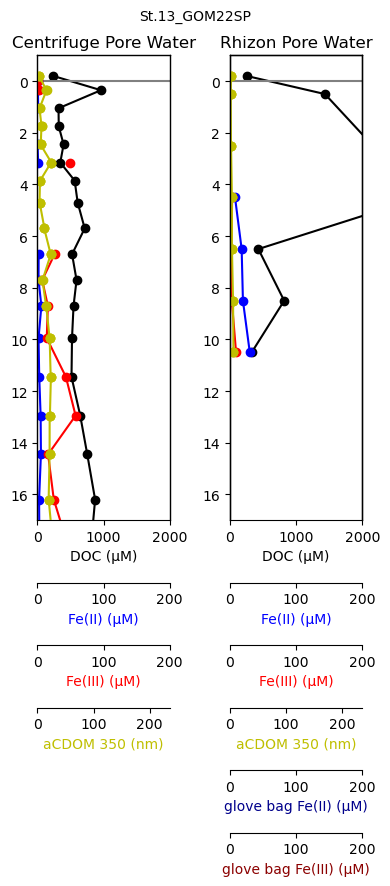

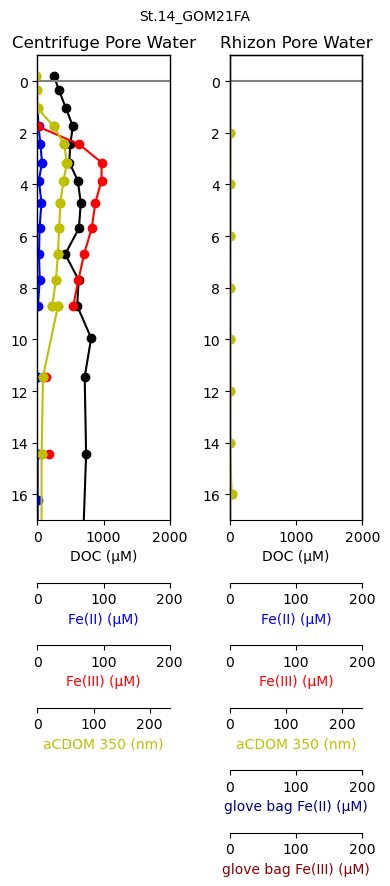

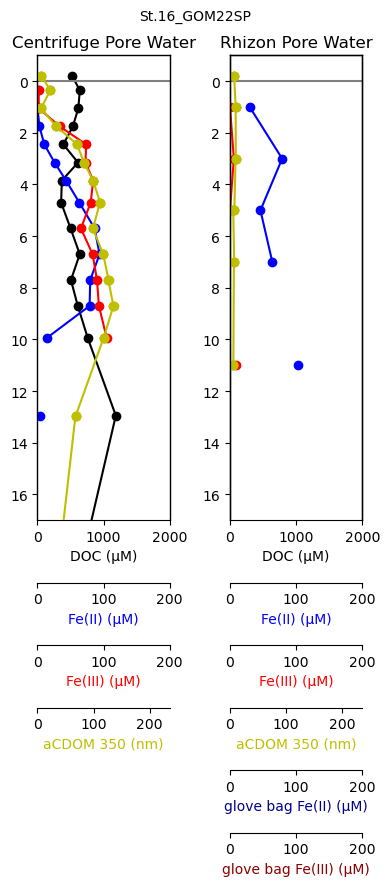

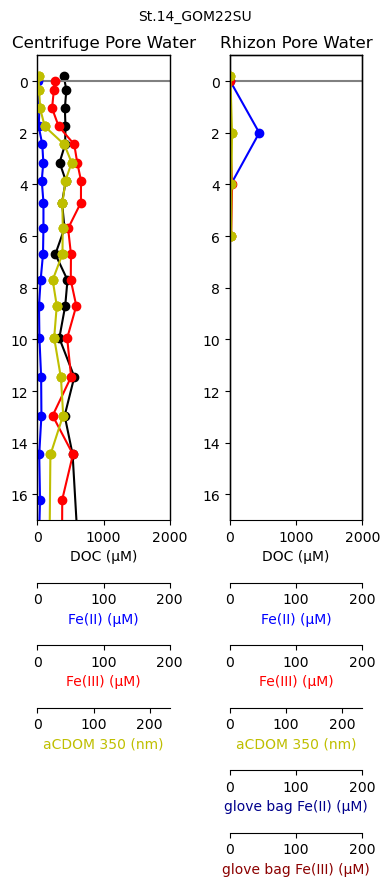

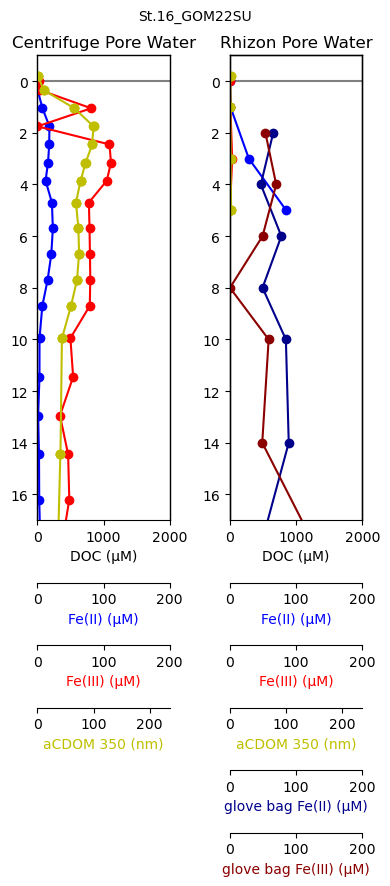

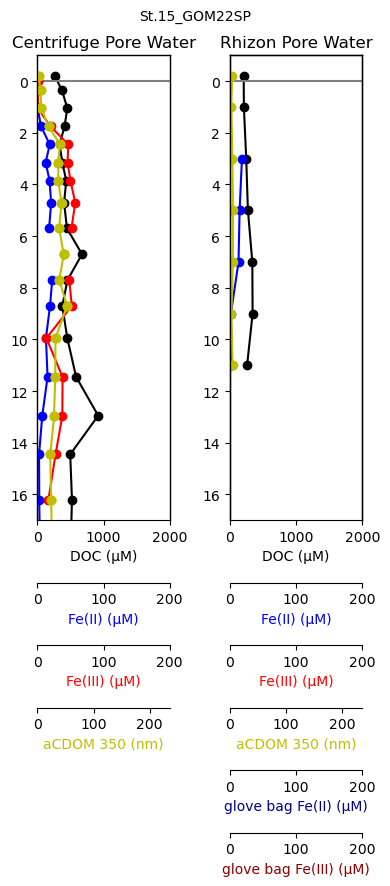

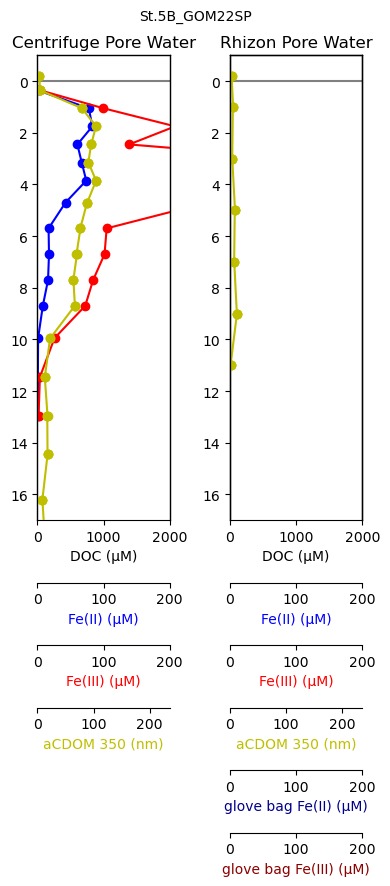

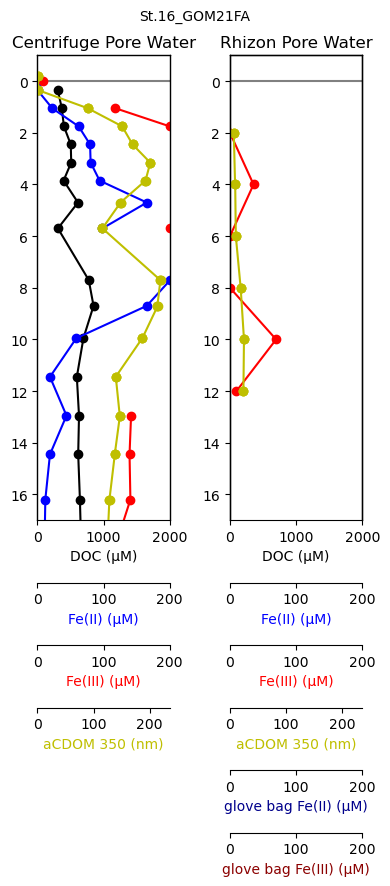

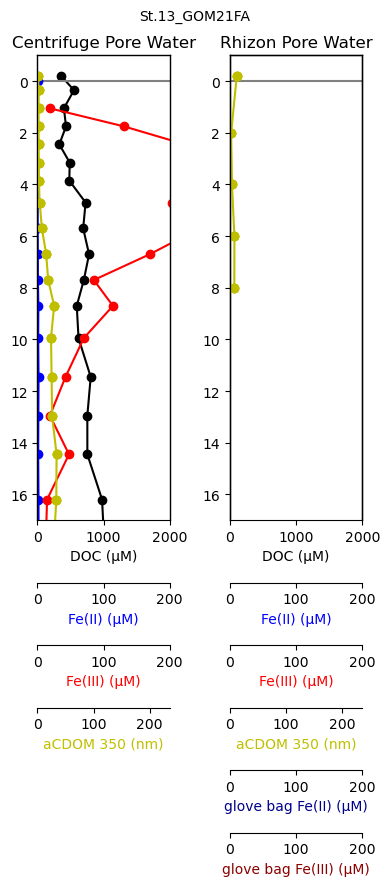

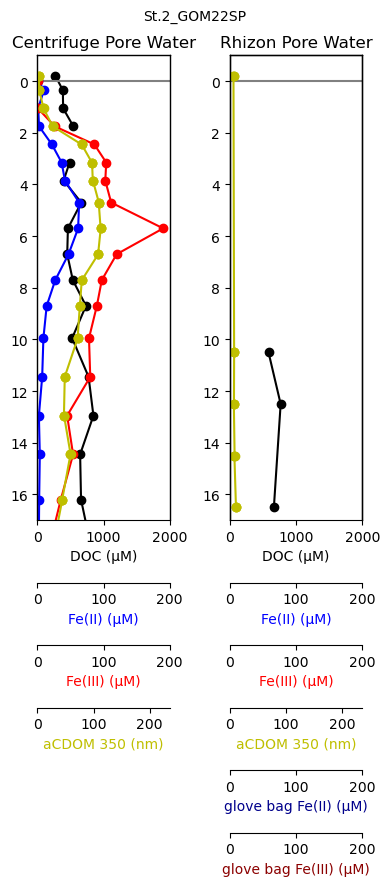

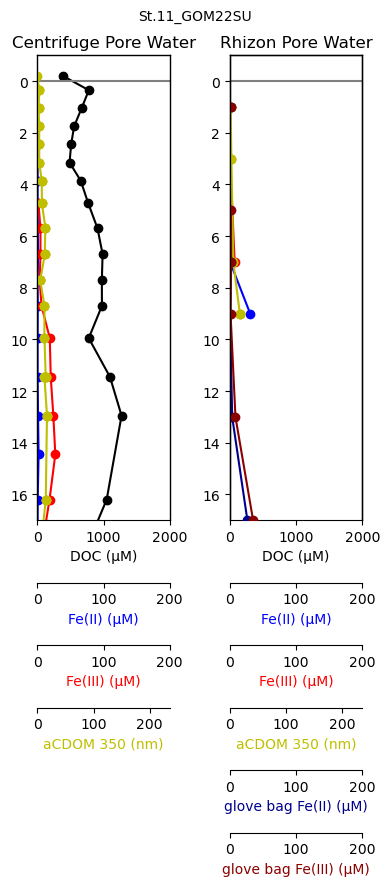

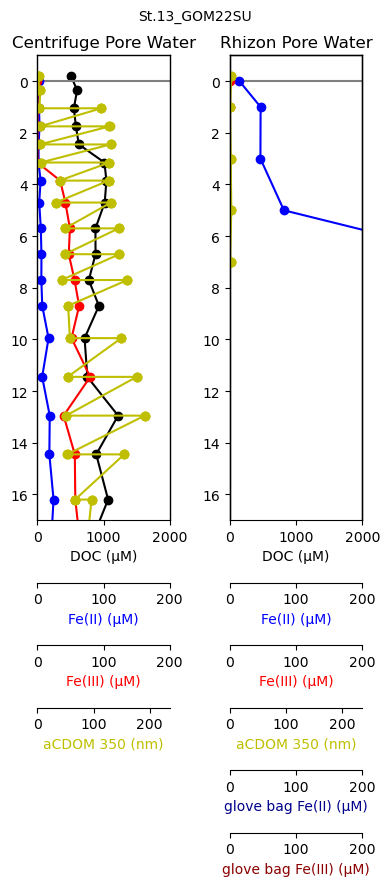

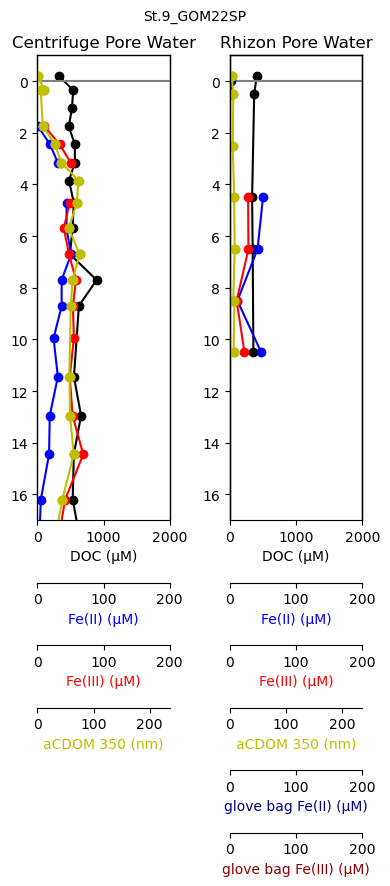

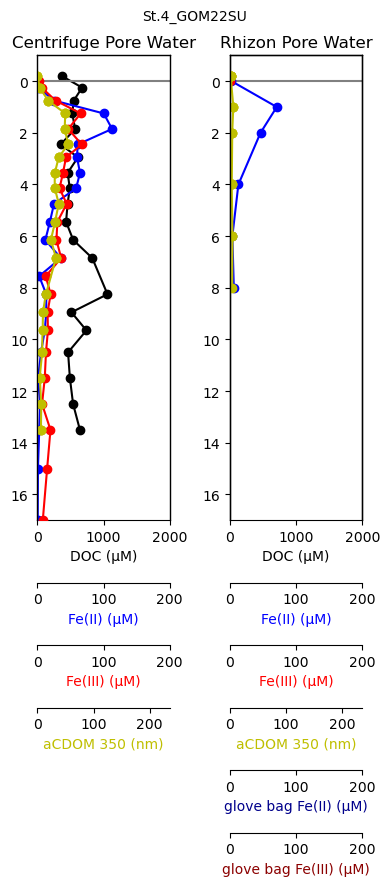

In [16]:
for code in codes_list: 
    #get data 
    data_cdom_pw = df_cdom_pw[df_cdom_pw['code'] == code] 
    data_cdom_rz = df_cdom_rz[df_cdom_rz['code'] == code]
    data_spectra_pw = df_spectra_pw[df_spectra_pw['code'] == code] 
    data_spectra_rz = df_spectra_rz[df_spectra_rz['code'] == code]
    data_iron_pw = df_iron_pw[df_iron_pw['code'] == code] 
    data_iron_rz = df_iron_rz[(df_iron_rz['code'] == code) & (df_iron_rz['Type'] == 'RZ')]
    data_iron_gb = df_iron_rz[(df_iron_rz['code'] == code) & (df_iron_rz['Type'] == 'GBRZ')]
    data_doc_pw = df_doc_pw[df_doc_pw['code'] == code] 
    data_doc_rz = df_doc_rz[df_doc_rz['code'] == code]
    
    #For Pore Waters 
    #get vars DOC 
    doc_uM_pw = data_doc_pw['NPOC_uM'] 
    doc_uM_pw = np.asarray(doc_uM_pw, dtype=float).ravel()
    tn_uM_pw = data_doc_pw['TN_uM'] 
    tn_uM_pw = np.asarray(tn_uM_pw, dtype=float).ravel()
    doc_depth_pw = data_doc_pw['Depth'] #X var 
    doc_depth_pw = np.asarray(doc_depth_pw, dtype=float).ravel()
    
    #get vars Fe
    fe2_uM_pw = data_iron_pw['Fe2_uM'] 
    fe2_uM_pw = np.asarray(fe2_uM_pw, dtype=float).ravel()
    fet_uM_pw = data_iron_pw['FeT_uM'] 
    fet_uM_pw = np.asarray(fet_uM_pw, dtype=float).ravel()
    fe3_uM_pw = data_iron_pw['Fe3_uM'] 
    fe3_uM_pw = np.asarray(fe3_uM_pw, dtype=float).ravel()
    fe_depth_pw = data_iron_pw['Fe2_Depth'] 
    fe_depth_pw = np.asarray(fe_depth_pw, dtype=float).ravel()
    
    #get vars CDOM
    a350_pw = data_spectra_pw['a350']
    a350_pw = np.asarray(a350_pw, dtype=float).ravel()
    aDepth_pw = data_spectra_pw['Sample_depth']
    aDepth_pw = np.asarray(aDepth_pw, dtype=float).ravel()
    
    #For Rhizon Waters
    # get vars DOC 
    doc_uM_rz = data_doc_rz['NPOC_uM'] 
    doc_uM_rz = np.asarray(doc_uM_rz, dtype=float).ravel()
    tn_uM_rz = data_doc_rz['TN_uM'] 
    tn_uM_rz = np.asarray(tn_uM_rz, dtype=float).ravel()
    doc_depth_rz = data_doc_rz['Depth'] #X var 
    doc_depth_rz = np.asarray(doc_depth_rz, dtype=float).ravel()

    # get vars Fe
    fe2_uM_rz = data_iron_rz['Fe2_uM'] 
    fe2_uM_rz = np.asarray(fe2_uM_rz, dtype=float).ravel()
    fet_uM_rz = data_iron_rz['FeT_uM'] 
    fet_uM_rz = np.asarray(fet_uM_rz, dtype=float).ravel()
    fe3_uM_rz = data_iron_rz['Fe3_uM'] 
    fe3_uM_rz = np.asarray(fe3_uM_rz, dtype=float).ravel()
    fe_depth_rz = data_iron_rz['Fe2_Depth'] 
    fe_depth_rz = np.asarray(fe_depth_rz, dtype=float).ravel()
    
    #get vars Fe glove bag 
    fe2_uM_gb = data_iron_gb['Fe2_uM'] 
    fe2_uM_gb = np.asarray(fe2_uM_gb, dtype=float).ravel()
    fet_uM_gb = data_iron_gb['FeT_uM'] 
    fet_uM_gb = np.asarray(fet_uM_gb, dtype=float).ravel()
    fe3_uM_gb = data_iron_gb['Fe3_uM'] 
    fe3_uM_gb = np.asarray(fe3_uM_gb, dtype=float).ravel()
    fe_depth_gb = data_iron_gb['Fe2_Depth'] 
    fe_depth_gb = np.asarray(fe_depth_gb, dtype=float).ravel()
    
    # get vars CDOM
    a350_rz = data_spectra_rz['a350']
    a350_rz = np.asarray(a350_rz, dtype=float).ravel()
    aDepth_rz = data_spectra_rz['Sample_depth']
    aDepth_rz = np.asarray(aDepth_rz, dtype=float).ravel()
    
    # Set up the color bar limits
    vmin = -.5
    vmax = 17
    scale_fac = 45
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(4, 9))
    
    #PLOT DOC cent 
    ax[0].plot(doc_uM_pw, doc_depth_pw, 'o', ls='-', c='black')
    ax[0].set_xlim(0,2000)
    ax[0].set_ylim(17,-1)
    ax[0].axhline(y=0, color='grey', linestyle='-', label='Sediment Water Interface')
    ax[0].set_title('Centrifuge Pore Water')
    ax[0].xaxis.set_ticks_position('bottom')
    ax[0].xaxis.set_label_position('bottom')
    ax[0].spines['bottom'].set_position(('outward', 0))
    ax[0].set_xlabel('DOC (\u03BCM)', size= 10)

    #PLOT DOC rhizon 
    ax[1].plot(doc_uM_rz, doc_depth_rz, 'o', ls='-', c='black')
    ax[1].set_xlim(0,2000)
    ax[1].set_ylim(17,-1)
    ax[1].axhline(y=0, color='grey', linestyle='-', label='Sediment Water Interface')
    ax[1].set_title('Rhizon Pore Water')
    ax[1].xaxis.set_ticks_position('bottom')
    ax[1].xaxis.set_label_position('bottom')
    ax[1].spines['bottom'].set_position(('outward', 0))
    ax[1].set_xlabel('DOC (\u03BCM)', size= 10)
        
    #plot Fe2 cent
    ax01 = ax[0].twiny()
    ax01.plot(fe2_uM_pw, fe_depth_pw, 'o', ls='-', c='b')
    ax01.set_xlim(0,200)
    # Set x-axis label on bottom subplots
    ax01.xaxis.set_ticks_position('bottom')
    ax01.xaxis.set_label_position('bottom')
    ax01.spines['bottom'].set_position(('outward', scale_fac))
    ax01.set_xlabel('Fe(II) (\u03BCM)', size= 10, c='b')
    
    #plot Fe2 rhz
    ax11 = ax[1].twiny()
    ax11.plot(fe2_uM_rz, fe_depth_rz, 'o', ls='-', c='b')
    ax11.set_xlim(0,200)
    # Set x-axis label on bottom subplots
    ax11.xaxis.set_ticks_position('bottom')
    ax11.xaxis.set_label_position('bottom')
    ax11.spines['bottom'].set_position(('outward', scale_fac))
    ax11.set_xlabel('Fe(II) (\u03BCM)', size= 10, c='b')
    
    #plot Fe3 cent
    ax02 = ax[0].twiny()
    ax02.plot(fe3_uM_pw, fe_depth_pw, 'o', ls='-', c='r')
    ax02.set_xlim(0,200)
    # Set x-axis label on bottom subplots
    ax02.xaxis.set_ticks_position('bottom')
    ax02.xaxis.set_label_position('bottom')
    ax02.spines['bottom'].set_position(('outward', scale_fac*2))
    ax02.set_xlabel('Fe(III) (\u03BCM)', size= 10, c='r')
    
    #plot Fe3 rhz
    ax12 = ax[1].twiny()
    ax12.plot(fe3_uM_rz, fe_depth_rz, 'o', ls='-', c='r')
    ax12.set_xlim(0,200)
    # Set x-axis label on bottom subplots
    ax12.xaxis.set_ticks_position('bottom')
    ax12.xaxis.set_label_position('bottom')
    ax12.spines['bottom'].set_position(('outward', scale_fac*2))
    ax12.set_xlabel('Fe(III) (\u03BCM)', size= 10, c='r')
    
    #plot cdom cent
    ax03 = ax[0].twiny()
    ax03.plot(a350_pw, aDepth_pw, 'o', ls='-', c='y')
    ax03.set_xlim(0,236)
    # Set x-axis label on bottom subplots
    ax03.xaxis.set_ticks_position('bottom')
    ax03.xaxis.set_label_position('bottom')
    ax03.spines['bottom'].set_position(('outward', scale_fac*3))
    ax03.set_xlabel('aCDOM 350 (nm)', size= 10, c='y')
    
    #plot cdom rhz
    ax13 = ax[1].twiny()
    ax13.plot(a350_rz, aDepth_rz, 'o', ls='-', c='y')
    ax13.set_xlim(0,236)
    # Set x-axis label on bottom subplots
    ax13.xaxis.set_ticks_position('bottom')
    ax13.xaxis.set_label_position('bottom')
    ax13.spines['bottom'].set_position(('outward', scale_fac*3))
    ax13.set_xlabel('aCDOM 350 (nm)', size= 10, c='y')
    
    #plot Fe2 rhz glove bag 
    ax111 = ax[1].twiny()
    ax111.plot(fe2_uM_gb, fe_depth_gb, 'o', ls='-', c='darkblue')
    ax111.set_xlim(0,200)
    # Set x-axis label on bottom subplots
    ax111.xaxis.set_ticks_position('bottom')
    ax111.xaxis.set_label_position('bottom')
    ax111.spines['bottom'].set_position(('outward', scale_fac*4))
    ax111.set_xlabel('glove bag Fe(II) (\u03BCM)', size= 10, c='darkblue')
    
    #plot Fe3 rhz glove bag 
    ax122 = ax[1].twiny()
    ax122.plot(fe3_uM_gb, fe_depth_gb, 'o', ls='-', c='darkred')
    ax122.set_xlim(0,200)
    # Set x-axis label on bottom subplots
    ax122.xaxis.set_ticks_position('bottom')
    ax122.xaxis.set_label_position('bottom')
    ax122.spines['bottom'].set_position(('outward', scale_fac*5))
    ax122.set_xlabel('glove bag Fe(III) (\u03BCM)', size= 10, c='darkred')
    
    fig.suptitle(code, size = 10)
    
    fig.set_facecolor('w')
    plt.tight_layout()
    plt.show()